In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import pandas as pd

from HARK.Calibration.Income.IncomeTools import (
    CGM_income,
    parse_income_spec,
    parse_time_params,
)
from HARK.ConsumptionSaving.ConsBequestModel import (
    BequestWarmGlowConsumerType,
    init_accidental_bequest,
)
from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True,
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to,
    age=birth_age,
    education=education,
    wave=1995,
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True,
    cross_sec=True,
    year=2004,
    min_age=birth_age,
    max_age=death_age - 1,
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_accidental_bequest)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": liv_prb})

In [3]:
# Make and solve an idiosyncratic shocks consumer with a finite lifecycle
Agent = BequestWarmGlowConsumerType(**params)
# Make this consumer live a sequence of periods exactly once
Agent.cycles = 1

In [4]:
start_time = time()
Agent.solve()
end_time = time()
print(f"Solving a lifecycle consumer took {end_time - start_time} seconds.")
Agent.unpack("cFunc")

Solving a lifecycle consumer took 0.2072460651397705 seconds.


Consumption functions


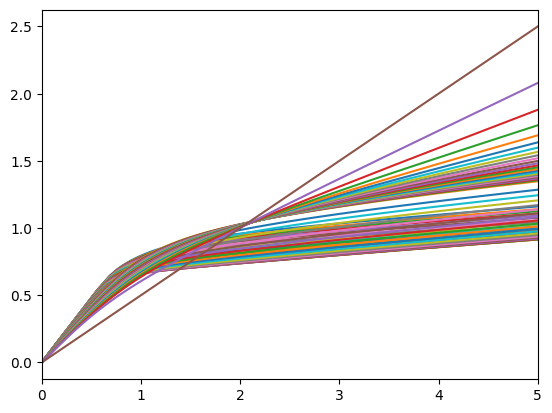

In [5]:
# Plot the consumption functions
print("Consumption functions")
plot_funcs(Agent.cFunc, 0, 5)

In [6]:
# Number of LifecycleExamples and periods in the simulation.
Agent.AgentCount = 500
Agent.T_sim = 200

# Set up the variables we want to keep track of.
Agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
Agent.initialize_sim()
Agent.simulate()

{'aNrm': array([[ 0.32380522,  0.68955532,  0.34197775, ...,  1.46693047,
          3.42320775,  0.23104866],
        [ 0.13306755,  0.54144539,  1.17330302, ...,  1.17214556,
          3.05300486,  1.1052612 ],
        [ 0.11375969,  0.78364427,  1.170144  , ...,  0.48155715,
          2.09446397,  0.95931916],
        ...,
        [ 1.98329928, 47.11068145,  5.60926002, ...,  5.47982373,
          2.97252781,  5.08850217],
        [ 2.09397696, 44.00732908,  6.38008957, ...,  4.99716316,
          2.57089877,  5.84933883],
        [ 2.22702697, 40.92172852,  5.32578927, ...,  5.61152821,
          2.92852871,  6.35404606]]),
 'cNrm': array([[0.84083875, 0.91732219, 0.84644168, ..., 0.99649981, 1.13416322,
         0.80614124],
        [0.74584474, 0.88143084, 0.95562365, ..., 0.95552339, 1.08946728,
         0.94958006],
        [0.72833189, 0.9074526 , 0.94451529, ..., 0.86333317, 1.01188232,
         0.92575319],
        ...,
        [1.00435376, 5.66117289, 1.02024892, ..., 1.0921

In [7]:
raw_data = {
    "Age": Agent.history["t_age"].flatten() + birth_age - 1,
    "pIncome": Agent.history["pLvl"].flatten(),
    "nrmM": Agent.history["mNrm"].flatten(),
    "nrmC": Agent.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

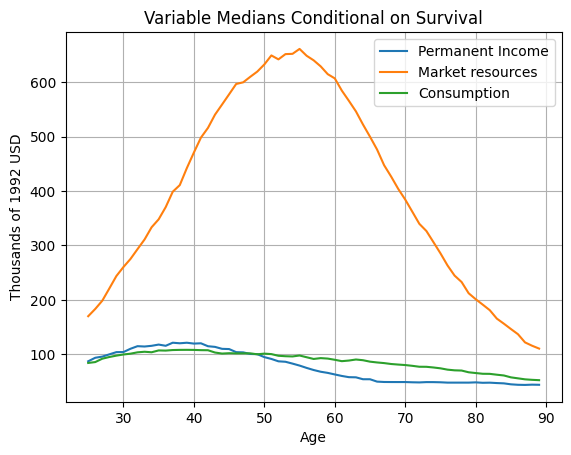

In [8]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel(f"Thousands of {adjust_infl_to} USD")
plt.title("Variable Medians Conditional on Survival")
plt.grid()